In [1]:
import torch
from sdf_utils import sap
import time
import random
import deep_sdf
from deep_sdf import mesh, metrics, lr_scheduling, plotting, utils, loss
import deep_sdf.workspace as ws
import json
import os
import reconstruct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_spec_with_default(specs, key, default):
    try:
        return specs[key]
    except KeyError:
        return default

In [3]:
experiment_directory = "examples/torus"
specs = ws.load_experiment_specifications(experiment_directory)
data_source = specs["DataSource"]
test_split_file = specs["TestSplit"]
with open(test_split_file, "r") as f:
    test_split = json.load(f)
eval_test_scene_num = get_spec_with_default(specs, "EvalTestSceneNumber", 10)
eval_test_optimization_steps = get_spec_with_default(specs, "EvalTestOptimizationSteps", 1000)
eval_grid_res = get_spec_with_default(specs, "EvalGridResolution", 256)
torus_path = get_spec_with_default(specs, "TorusPath", "/home/jakaria//torus_two_models_data/torus_two/obj_files")

In [4]:
arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])
latent_size = specs["CodeLength"]

decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])
decoder = torch.nn.DataParallel(decoder)

saved_model_state = torch.load(
    os.path.join(
        experiment_directory, ws.model_params_subdir, "latest" + ".pth"
    )
)
saved_model_epoch = saved_model_state["epoch"]

decoder.load_state_dict(saved_model_state["model_state_dict"])
decoder = decoder.module.cuda()
decoder.eval()

Decoder(
  (lin0): Linear(in_features=19, out_features=512, bias=True)
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=493, bias=True)
  (lin4): Linear(in_features=512, out_features=512, bias=True)
  (lin5): Linear(in_features=512, out_features=512, bias=True)
  (lin6): Linear(in_features=512, out_features=512, bias=True)
  (lin7): Linear(in_features=512, out_features=512, bias=True)
  (lin8): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
  (th): Tanh()
)

In [5]:
eval_test_time_start = time.time()
test_err_sum = 0.
chamfer_dists = []
chamfer_dists_all = []
test_loss_hists = []
mesh_label_names = []
test_latents = []

In [6]:
eval_test_filenames = deep_sdf.data.get_instance_filenames(data_source, test_split)
eval_test_filenames = random.sample(eval_test_filenames, min(eval_test_scene_num, len(eval_test_filenames)))

Reconstructing /home/jakaria/torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/sdf_data/SdfSamples/obj_files/torus_bump_3175.npz...
Reconstruction of /home/jakaria/torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/sdf_data/SdfSamples/obj_files/torus_bump_3175.npz took 9.373128890991211 seconds.
Creating mesh for /home/jakaria/torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/sdf_data/SdfSamples/obj_files/torus_bump_3175.npz...
Mesh creation for /home/jakaria/torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/sdf_data/SdfSamples/obj_files/torus_bump_3175.npz took 8.722023725509644 seconds.
Reconstructing /home/jakaria/torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/sdf_data/SdfSamples/obj_files/torus_bump_0848.npz...
Reconstruction of /home/jakaria/torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/sdf_data/SdfSamples/obj_files/torus_bump_0848.npz took 9.053242683410645 seconds.
Creating mesh for /

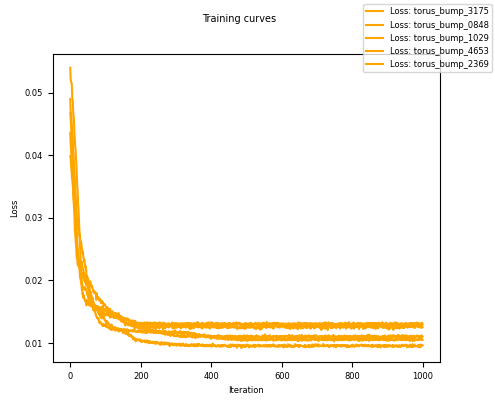

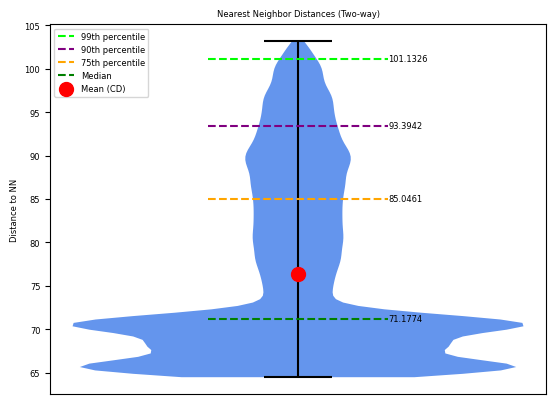

In [7]:
for test_fname in eval_test_filenames:
    save_name = os.path.basename(test_fname).split(".npz")[0]
    mesh_label_names.append(save_name)
    path = os.path.join(experiment_directory, "test_contrastive_one", ws.tb_logs_test_reconstructions, save_name)
    if not os.path.exists(path):
        os.makedirs(path)
        
    test_fpath = os.path.join(data_source, ws.sdf_samples_subdir, test_fname)
    test_sdf_samples = deep_sdf.data.read_sdf_samples_into_ram(test_fpath)
    test_sdf_samples[0] = test_sdf_samples[0][torch.randperm(test_sdf_samples[0].shape[0])]
    test_sdf_samples[1] = test_sdf_samples[1][torch.randperm(test_sdf_samples[1].shape[0])]

    start = time.time()
    print(f"Reconstructing {test_fname}...")
    test_loss_hist, test_latent = reconstruct.reconstruct(
        decoder,
        int(eval_test_optimization_steps),
        latent_size,
        test_sdf_samples,
        0.01,  # [emp_mean,emp_var],
        0.1,
        num_samples=8000,
        lr=5e-3,
        l2reg=True,
        return_loss_hist=True
    )
    
    if not np.isnan(test_loss_hist[-1]):
        test_err_sum += test_loss_hist[-1]
    test_loss_hists.append(test_loss_hist)
    test_latents.append(test_latent)
    print(f"Reconstruction of {test_fname} took {time.time()-start} seconds.")

    print(f"Creating mesh for {test_fname}...")
    start = time.time()
    with torch.no_grad():
        test_mesh = mesh.create_mesh(
            decoder, 
            test_latent, 
            N=eval_grid_res, 
            max_batch=int(2 ** 18), 
            filename=os.path.join(path, f"epoch={saved_model_epoch}"),
            return_trimesh=True,
        )
    print(f"Mesh creation for {test_fname} took {time.time()-start} seconds.")

    if test_mesh is not None:
        gt_mesh_path = f"{torus_path}/{save_name}.obj"
        cd, cd_all = metrics.compute_metric(gt_mesh=gt_mesh_path, gen_mesh=test_mesh, metric="chamfer")
        chamfer_dists.append(cd)
        chamfer_dists_all.append(cd_all)

    del test_sdf_samples, test_mesh

if chamfer_dists:
    mlm = torch.mean(torch.norm(torch.cat(test_latents, dim=0), dim=1))
    fig = plotting.plot_train_stats(loss_hists=test_loss_hists, labels=mesh_label_names)
    fig, percentiles = plotting.plot_dist_violin(np.concatenate(chamfer_dists_all, axis=0))
    for p in [75, 90, 99]:
        if p in percentiles:
            print(f"CD Percentile {p}th: {percentiles[p]}")
    
    plt.show(fig)